In [1]:
# hello world
import numpy, pandas, xarray
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("Xarray:", xarray.__version__)

NumPy: 2.3.3
Pandas: 2.3.3
Xarray: 2025.4.0


In [2]:
import xarray as xr
import regionmask
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs# For map plotting
#1) Load the data with Dask
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/totprecip.nc'
# Use Dask to load the dataset with chunking
ds = xr.open_dataset(file_path)
ds = ds.rename({'valid_time': 'time'})

# 2) Inspect the dataset
print(ds)

<xarray.Dataset> Size: 53MB
Dimensions:    (time: 909, latitude: 121, longitude: 121)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2025-09-01
  * latitude   (latitude) float64 968B 61.0 60.9 60.8 60.7 ... 49.2 49.1 49.0
  * longitude  (longitude) float64 968B -10.0 -9.9 -9.8 -9.7 ... 1.7 1.8 1.9 2.0
    expver     (time) <U4 15kB ...
Data variables:
    tp         (time, latitude, longitude) float32 53MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-20T17:31 GRIB to CDM+CF via cfgrib-0.9.1...


In [3]:
print(ds.longitude.values[:150])

[-1.00000000e+01 -9.90000000e+00 -9.80000000e+00 -9.70000000e+00
 -9.60000000e+00 -9.50000000e+00 -9.40000000e+00 -9.30000000e+00
 -9.20000000e+00 -9.10000000e+00 -9.00000000e+00 -8.90000000e+00
 -8.80000000e+00 -8.70000000e+00 -8.60000000e+00 -8.50000000e+00
 -8.40000000e+00 -8.30000000e+00 -8.20000000e+00 -8.10000000e+00
 -8.00000000e+00 -7.90000000e+00 -7.80000000e+00 -7.70000000e+00
 -7.60000000e+00 -7.50000000e+00 -7.40000000e+00 -7.30000000e+00
 -7.20000000e+00 -7.10000000e+00 -7.00000000e+00 -6.90000000e+00
 -6.80000000e+00 -6.70000000e+00 -6.60000000e+00 -6.50000000e+00
 -6.40000000e+00 -6.30000000e+00 -6.20000000e+00 -6.10000000e+00
 -6.00000000e+00 -5.90000000e+00 -5.80000000e+00 -5.70000000e+00
 -5.60000000e+00 -5.50000000e+00 -5.40000000e+00 -5.30000000e+00
 -5.20000000e+00 -5.10000000e+00 -5.00000000e+00 -4.90000000e+00
 -4.80000000e+00 -4.70000000e+00 -4.60000000e+00 -4.50000000e+00
 -4.40000000e+00 -4.30000000e+00 -4.20000000e+00 -4.10000000e+00
 -4.00000000e+00 -3.90000

Found United Kingdom in regionmask (index = 143)
Applied UK regionmask to variable 'tp'
909


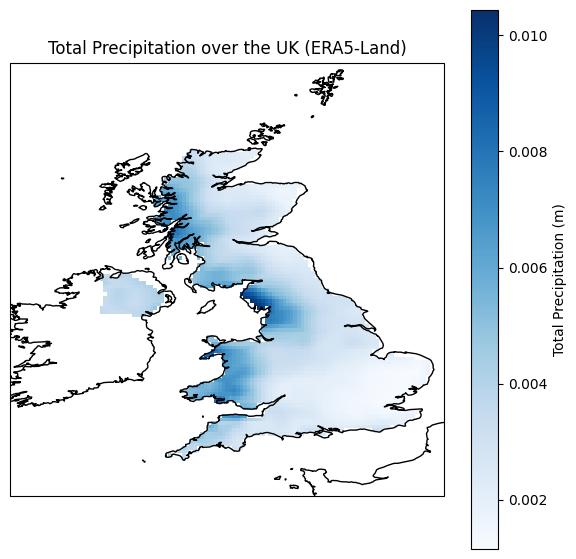

In [4]:
varname = 'tp'

# --- 3) Subset roughly to UK bounding box (optional, speeds up masking) ---
ds = ds.sel(latitude=slice(61, 49), longitude=slice(-10, 2))

# --- 4) Define regionmask for UK using Natural Earth polygons ---
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
print(f"Found United Kingdom in regionmask (index = {uk_index})")

# --- 5) Create and apply mask ---
mask = countries.mask(lon_or_obj=ds.longitude, lat=ds.latitude)

#mask = countries.mask(ds)
uk_data = ds[varname].where(mask == uk_index)
print(f"Applied UK regionmask to variable '{varname}'")
print(len(uk_data.time))

# --- 6) Plot the first timestep of the masked data ---
plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
uk_data.isel(time=908).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
    cbar_kwargs={'label': 'Total Precipitation (m)'}
)
ax.coastlines()
plt.title(f"Total Precipitation over the UK (ERA5-Land)")
plt.show()



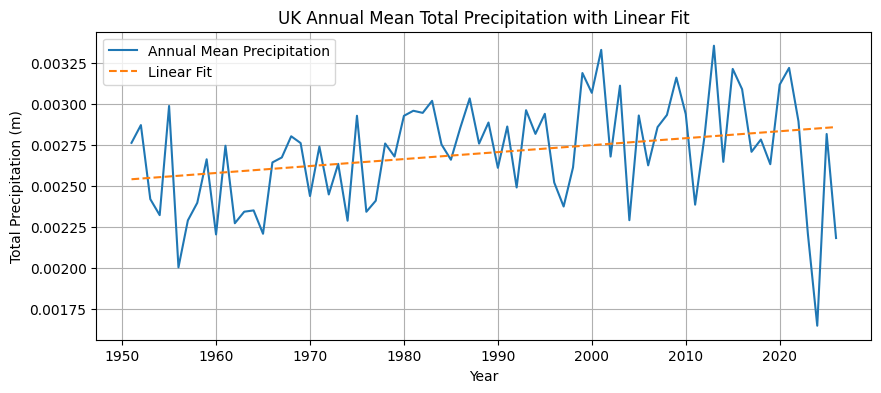

In [19]:

uk_annual = uk_data.mean(dim=['latitude','longitude'], skipna=True).resample(time='YE').mean()

# --- Linear fit ---
import numpy as np

y = uk_annual.values
x = np.arange(len(y))  # 0,1,2,... years
coeffs = np.polyfit(x, y, 1)  # linear fit
fit = np.polyval(coeffs, x)

# --- Plot ---
plt.figure(figsize=(10,4))
plt.plot(uk_annual['time'], y, label='Annual Mean Precipitation')
plt.plot(uk_annual['time'], fit, '--', label=f'Linear Fit')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (m)')
plt.title('UK Annual Mean Total Precipitation with Linear Fit')
plt.legend()
plt.grid(True)
plt.show()


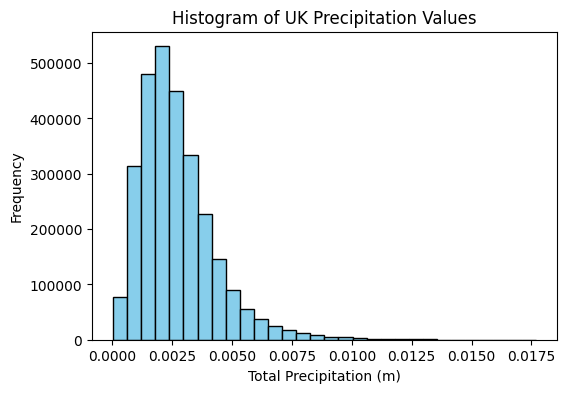

In [20]:
# Flatten all values into 1D array, ignoring NaNs
data_flat = uk_data.values.flatten()
data_flat = data_flat[~np.isnan(data_flat)]

plt.figure(figsize=(6,4))
plt.hist(data_flat, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Total Precipitation (m)')
plt.ylabel('Frequency')
plt.title('Histogram of UK Precipitation Values')
plt.show()


In [22]:
print(ds.tp)

<xarray.DataArray 'tp' (time: 909, latitude: 121, longitude: 121)> Size: 53MB
[13308669 values with dtype=float32]
Coordinates:
    number     int64 8B 0
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2025-09-01
  * latitude   (latitude) float64 968B 61.0 60.9 60.8 60.7 ... 49.2 49.1 49.0
  * longitude  (longitude) float64 968B -10.0 -9.9 -9.8 -9.7 ... 1.7 1.8 1.9 2.0
    expver     (time) <U4 15kB ...
Attributes: (12/31)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      14641
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                      

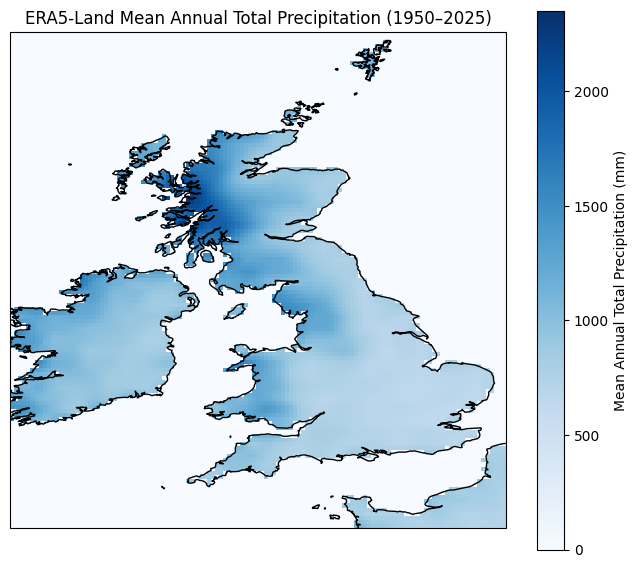

In [91]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# --- 1. Load the dataset ---
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/totprecip.nc'
ds = xr.open_dataset(file_path)
ds = ds.rename({'valid_time': 'time'})

tp = ds['tp']  # total precipitation (m/day)

# --- 2. Compute number of days in each month ---
# make a DataArray aligned with tp.time
days_in_month = xr.DataArray(
    [pd.Timestamp(t.values).days_in_month for t in tp['time']],
    coords=[tp['time']],
    dims=['time']
)

# --- 3. Multiply each monthly mean by number of days to get monthly total (m/month) ---
tp_monthly_total = tp * days_in_month

# --- 4. Sum 12 months to get yearly totals ---
tp_yearly_total = tp_monthly_total.resample(time='YE').sum()

# --- 5. Compute mean annual total over all years (1950–2025) ---
tp_climatology = tp_yearly_total.mean(dim='time') * 1000  # convert m → mm

# --- 6. Plot ---
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
tp_climatology.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
    cbar_kwargs={'label': 'Mean Annual Total Precipitation (mm)'}
)
ax.coastlines()
ax.set_title('ERA5-Land Mean Annual Total Precipitation (1950–2025)')
plt.show()

In [64]:
# Select January 2025 and nearest Heathrow grid cell
tp = ds['tp']
tp_jan2025 = tp.sel(
    time='2025-01-01',
    longitude=-0.452,
    latitude=51.479,
    method='nearest'
)
print("Raw ERA5-Land value (m):", float(tp_jan2025.values))

tp_may2020 = tp.sel(
    time='2020-05-01',
    longitude=-0.452,
    latitude=51.479,
    method='nearest'
)
print("Raw ERA5-Land value (m):", float(tp_may2020.values))

tp_may2024 = tp.sel(
    time='2024-05-01',
    longitude=-0.452,
    latitude=51.479,
    method='nearest'
)
print("Raw ERA5-Land value (m):", float(tp_may2024.values))

tp_nov2019 = tp.sel(
    time='2019-11-01',
    longitude=-0.452,
    latitude=51.479,
    method='nearest'
)
print("Raw ERA5-Land value (m):", float(tp_nov2019.values))


Raw ERA5-Land value (m): 0.0025489781983196735
Raw ERA5-Land value (m): 0.0001331416715402156
Raw ERA5-Land value (m): 0.002616112818941474
Raw ERA5-Land value (m): 0.003058304311707616


In [63]:
tp_mm_days = float(tp_jan2025.values) * 31 * 1000
tp_mm = float(tp_may2020.values) * 31 * 1000
tp1_mm = float(tp_may2024.values) * 31 * 1000
tp2_mm = float(tp_nov2019.values) * 30 * 1000

print(f"ERA5-Land value (January 2025, Heathrow): {tp_mm_days:.3f} mm")
print(f"ERA5-Land value (May 2020, Heathrow): {tp_mm:.3f} mm")
print(f"ERA5-Land value (May 2024, Heathrow): {tp1_mm:.3f} mm")
print(f"ERA5-Land value (November 2019, Heathrow): {tp2_mm:.3f} mm")

ERA5-Land value (January 2025, Heathrow): 79.018 mm
ERA5-Land value (May 2020, Heathrow): 4.127 mm
ERA5-Land value (May 2024, Heathrow): 81.099 mm
ERA5-Land value (November 2019, Heathrow): 91.749 mm


In [68]:
tp = ds['tp']  # total precipitation (m/day)
heathrow_lat, heathrow_lon = 51.479, -0.452

# Select Heathrow grid cell (nearest point)
tp_heathrow = tp.sel(latitude=heathrow_lat, longitude=heathrow_lon, method="nearest")

# Select only the year 2024
tp_2024 = tp_heathrow.sel(time=slice("2024-01-01", "2024-12-31"))

# Convert daily average (m/day) → monthly total (m)
days_in_month = tp_2024['time'].dt.days_in_month
tp_2024_monthly_m = tp_2024 * days_in_month

# Convert to mm
tp_2024_monthly_mm = tp_2024_monthly_m * 1000

# Put into pandas Series for clean output
tp_2024_series = tp_2024_monthly_mm.to_series()
tp_2024_series.index = tp_2024_series.index.strftime("%b %Y")  # nice month names

print("\n Heathrow 2024 monthly total precipitation (mm):")
print(tp_2024_series.round(2))

print(f"\nSum of 12 months (mm): {tp_2024_series.sum():.1f}")



 Heathrow 2024 monthly total precipitation (mm):
time
Jan 2024     23.06
Feb 2024     59.79
Mar 2024     83.49
Apr 2024     63.07
May 2024     81.10
Jun 2024     21.43
Jul 2024     75.68
Aug 2024     37.44
Sep 2024    147.58
Oct 2024     57.30
Nov 2024     80.81
Dec 2024     50.99
dtype: float64

Sum of 12 months (mm): 781.7


<xarray.Dataset> Size: 53MB
Dimensions:     (valid_time: 909, latitude: 121, longitude: 121)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 7kB 1950-01-01 ... 2025-09-01
  * latitude    (latitude) float64 968B 61.0 60.9 60.8 60.7 ... 49.2 49.1 49.0
  * longitude   (longitude) float64 968B -10.0 -9.9 -9.8 -9.7 ... 1.8 1.9 2.0
    expver      (valid_time) <U4 15kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 53MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-20T17:31 GRIB to CDM+CF via cfgrib-0.9.1...

✅ Yearly totals computed:
<xarray.DataArray (year: 76, latitude: 121, longitude: 121)> Size: 9MB
array([[[0.        , 0.        , 0.        , ..., 0.     

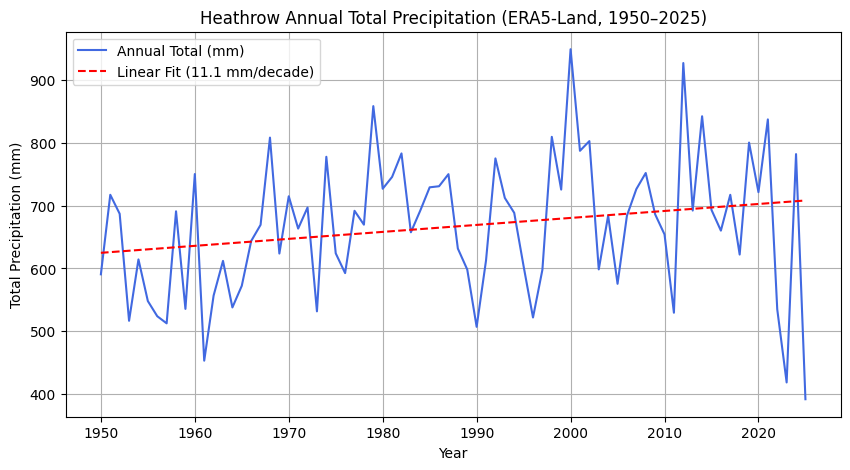


📈 Trend ≈ 11.09 mm per decade

Average annual total (1950–2025): 666.4 mm ± 110.8 mm


In [66]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/totprecip.nc'

# Open dataset (no need for chunks if it’s small enough)
ds = xr.open_dataset(file_path)
varname = 'tp'   # total precipitation variable name
print(ds)
# rename if needed
if 'valid_time' in ds.dims:
    ds = ds.rename({'valid_time': 'time'})

# 3. Convert from "m per day" to "m per month" and then "m per year"
# ===============================================================

# Each monthly value in ERA5-Land is the *average per day* for that month
# Multiply by number of days per month to get total precipitation per month
days_in_month = ds['time'].dt.days_in_month
monthly_total = ds[varname] * days_in_month

# Group by year → sum 12 months together to get yearly total per grid cell
yearly_totals = monthly_total.groupby('time.year').sum(dim='time')

print("\n✅ Yearly totals computed:")
print(yearly_totals)

# ===============================================================
# 4. Extract Heathrow location
# ===============================================================
heathrow_lat = 51.479
heathrow_lon = -0.452

# Select the nearest grid cell to Heathrow
heathrow_data = yearly_totals.sel(latitude=heathrow_lat,
                                  longitude=heathrow_lon,
                                  method='nearest')

# Convert to pandas Series and change units m → mm
heathrow_series = heathrow_data.to_series() * 1000
heathrow_series.index.name = "Year"

print("\n Heathrow annual total precipitation (mm):")
print(heathrow_series.head(10))
print(heathrow_series.tail(10))

# ===============================================================
# 5. Plot annual totals with linear trend
# ===============================================================

# Linear regression
x = np.arange(len(heathrow_series))
y = heathrow_series.values
coeffs = np.polyfit(x, y, 1)
fit = np.polyval(coeffs, x)
trend_per_decade = coeffs[0] * 10  # mm/decade

# Plot
plt.figure(figsize=(10, 5))
plt.plot(heathrow_series.index, y, label='Annual Total (mm)', color='royalblue')
plt.plot(heathrow_series.index, fit, '--', color='red', label=f'Linear Fit ({trend_per_decade:.1f} mm/decade)')
plt.title('Heathrow Annual Total Precipitation (ERA5-Land, 1950–2025)')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n📈 Trend ≈ {trend_per_decade:.2f} mm per decade")

# ===============================================================
# 6. Optional: print mean and std for reference
# ===============================================================
mean_rain = heathrow_series.mean()
std_rain = heathrow_series.std()
print(f"\nAverage annual total (1950–2025): {mean_rain:.1f} mm ± {std_rain:.1f} mm")



--- Linear fit parameters ---
Slope = 1.216 ± 0.579 mm/year
Intercept = 835.1 ± 25.2 mm
Z-score (slope/sigma) = 2.10
Trend (1950–2025): 92.4 mm total change over 75 years


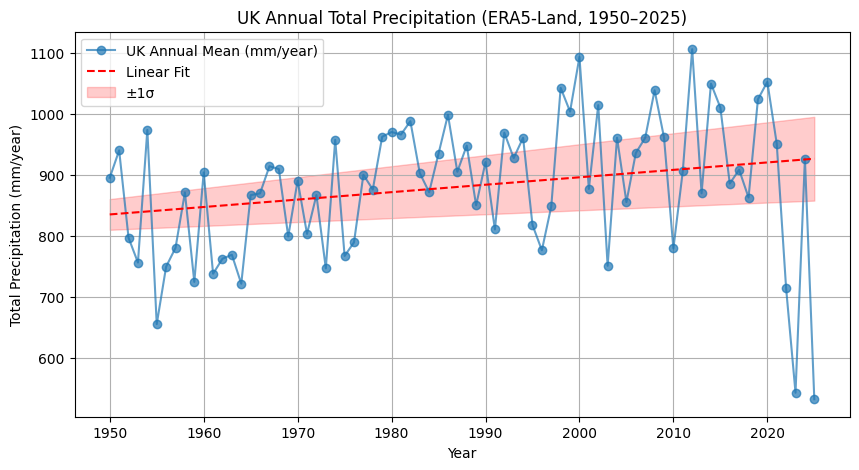


Mean annual precipitation (UK): 880.7 mm/year
Min: 532.6 mm, Max: 1105.6 mm


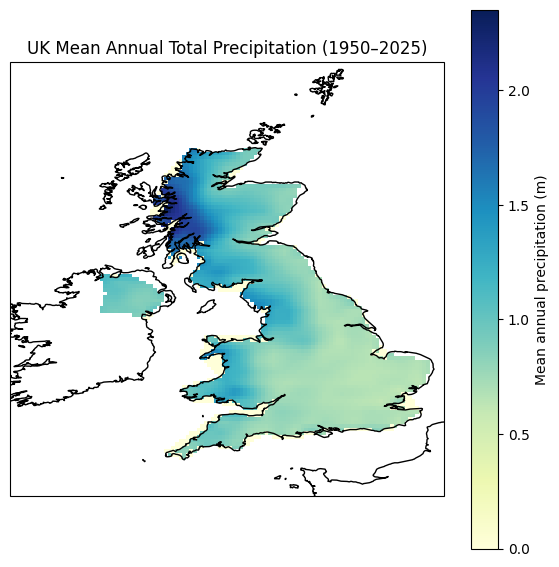

In [101]:
import xarray as xr
import regionmask
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/totprecip.nc'
ds = xr.open_dataset(file_path)
varname = 'tp'  # total precipitation

# Rename for regionmask
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})

# -------------------------
# Compute monthly totals (m/month)
# -------------------------
days_in_month = ds['valid_time'].dt.days_in_month
monthly_total = ds[varname] * days_in_month  # m/month

# -------------------------
# Compute yearly totals (m/year)
# -------------------------
yearly_totals = monthly_total.groupby('valid_time.year').sum(dim='valid_time')

# -------------------------
# Mask UK grid cells
# -------------------------
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
uk_mask = countries.mask(yearly_totals) == uk_index  # True for UK cells

uk_data = yearly_totals.where(uk_mask)

# -------------------------
# Compute area-weighted UK annual mean (mm/year)
# -------------------------
lat_radians = np.deg2rad(uk_data['lat'])
weights = np.cos(lat_radians)
uk_weighted_mean = ((uk_data * weights).sum(dim=['lat', 'lon'], skipna=True) /
                    weights.where(~np.isnan(uk_data)).sum(dim=['lat', 'lon'], skipna=True))

uk_annual_mm = uk_weighted_mean * 1000  # convert m → mm

# -------------------------
# Linear fit
# -------------------------
years = uk_annual_mm['year'].values
y = uk_annual_mm.values
x = np.arange(len(y))

# Fit and retrieve covariance matrix
p, cov = np.polyfit(x, y, 1, cov=True)
slope, intercept = p
slope_err, intercept_err = np.sqrt(np.diag(cov))

# Compute z-score for slope significance
z_score = slope / slope_err

print("\n--- Linear fit parameters ---")
print(f"Slope = {slope:.3f} ± {slope_err:.3f} mm/year")
print(f"Intercept = {intercept:.1f} ± {intercept_err:.1f} mm")
print(f"Z-score (slope/sigma) = {z_score:.2f}")
print(f"Trend (1950–2025): {slope * len(y):.1f} mm total change over 75 years")

# --- Plot UK annual precipitation with linear trend with ±1σ uncertainty band ---
plt.figure(figsize=(10,5))
plt.plot(years, y, 'o-', label='UK Annual Mean (mm/year)', alpha=0.7)

# Linear fit and ±1σ envelope
y_fit = np.polyval(p, x)
y_fit_upper = np.polyval([slope + slope_err, intercept + intercept_err], x)
y_fit_lower = np.polyval([slope - slope_err, intercept - intercept_err], x)

plt.plot(years, y_fit, 'r--', label='Linear Fit')
plt.fill_between(years, y_fit_lower, y_fit_upper, color='r', alpha=0.2, label='±1σ')

plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm/year)')
plt.title('UK Annual Total Precipitation (ERA5-Land, 1950–2025)')
plt.grid(True)
plt.legend()
plt.show()

# -------------------------
# Sanity check on mean value range
# -------------------------
print(f"\nMean annual precipitation (UK): {np.nanmean(y):.1f} mm/year")
print(f"Min: {np.nanmin(y):.1f} mm, Max: {np.nanmax(y):.1f} mm")

# -------------------------
# Plot UK spatial map (long-term mean)
# -------------------------
uk_mean_map = uk_data.mean(dim='year', skipna=True)

plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())
uk_mean_map.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='YlGnBu',
    cbar_kwargs={'label': 'Mean annual precipitation (m)'}
)
ax.coastlines()
plt.title("UK Mean Annual Total Precipitation (1950–2025)")
plt.show()



--- Linear fit (excluding 2022–2025) ---
Slope = 2.418 ± 0.482 mm/year
Intercept = 806.1 ± 19.8 mm
Z-score (slope/sigma) = 5.02
Trend (1950–2021): 174.1 mm total change over 72 years


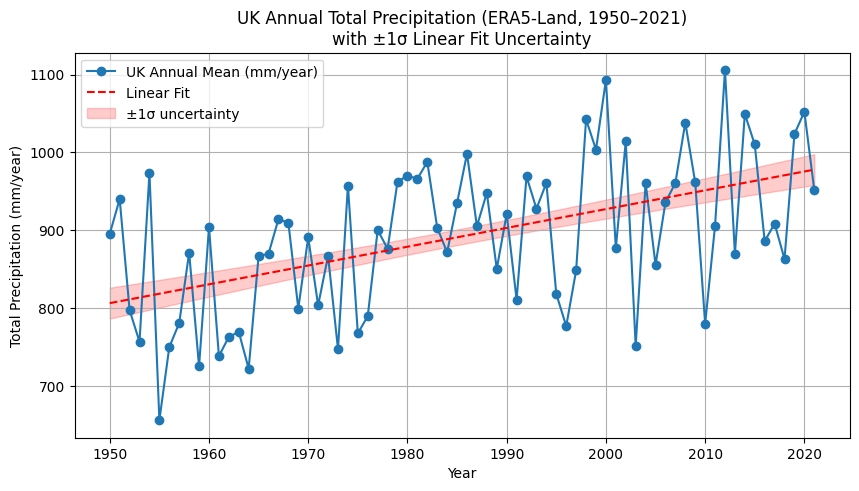

In [107]:
# Trim the last 4 years
y_trimmed = y[:-4]
x_trimmed = np.arange(len(y_trimmed))
years_trimmed = years[:-4]

# Linear fit with covariance for uncertainty
coeffs_trimmed, cov_trimmed = np.polyfit(x_trimmed, y_trimmed, 1, cov=True)
slope_trimmed, intercept_trimmed = coeffs_trimmed
errors_trimmed = np.sqrt(np.diag(cov_trimmed))
slope_err_trimmed, intercept_err_trimmed = errors_trimmed

# Z-score for slope significance
z_trimmed = slope_trimmed / slope_err_trimmed  

# Print results
print("\n--- Linear fit (excluding 2022–2025) ---")
print(f"Slope = {slope_trimmed:.3f} ± {slope_err_trimmed:.3f} mm/year")
print(f"Intercept = {intercept_trimmed:.1f} ± {intercept_err_trimmed:.1f} mm")
print(f"Z-score (slope/sigma) = {z_trimmed:.2f}")
print(f"Trend (1950–2021): {slope_trimmed * len(y_trimmed):.1f} mm total change over {len(y_trimmed)} years")

# Predicted line
y_fit = intercept_trimmed + slope_trimmed * x_trimmed

# --- Compute ±1σ confidence band ---
# Propagate covariance uncertainty for each x
y_std = np.sqrt(
    cov_trimmed[0,0]*x_trimmed**2 +   # var(slope)*x^2
    cov_trimmed[1,1] +                # var(intercept)
    2*x_trimmed*cov_trimmed[0,1]      # 2*cov(slope,intercept)*x
)

# -------------------------
# Plot trimmed annual precipitation and linear trend + 1σ band
# -------------------------
plt.figure(figsize=(10,5))
plt.plot(years_trimmed, y_trimmed, 'o-', label='UK Annual Mean (mm/year)')
plt.plot(years_trimmed, y_fit, 'r--', label='Linear Fit')
plt.fill_between(years_trimmed, y_fit - y_std, y_fit + y_std, color='r', alpha=0.2, label='±1σ uncertainty')

plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm/year)')
plt.title('UK Annual Total Precipitation (ERA5-Land, 1950–2021)\nwith ±1σ Linear Fit Uncertainty')
plt.grid(True)
plt.legend()
plt.show()


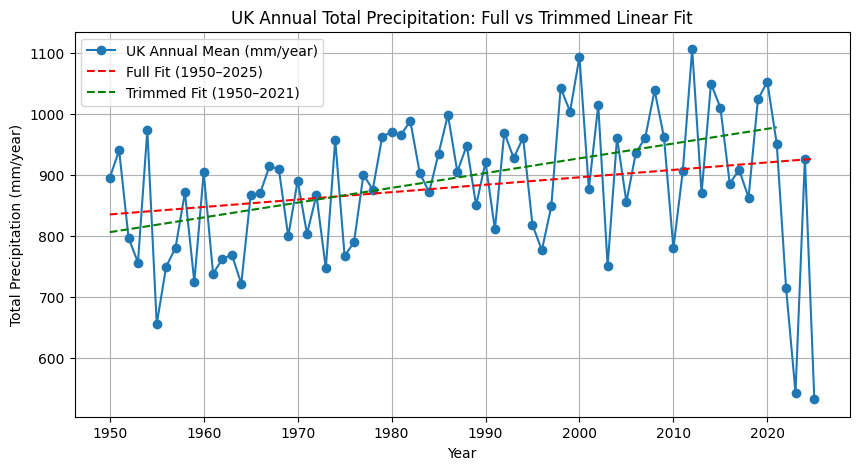

In [106]:
# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(years, y, 'o-', label='UK Annual Mean (mm/year)')
plt.plot(years, intercept + slope * x, 'r--', label='Full Fit (1950–2025)')
plt.plot(years_trimmed, intercept_trimmed + slope_trimmed * x_trimmed, 'g--', label='Trimmed Fit (1950–2021)')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm/year)')
plt.title('UK Annual Total Precipitation: Full vs Trimmed Linear Fit')
plt.grid(True)
plt.legend()
plt.show()

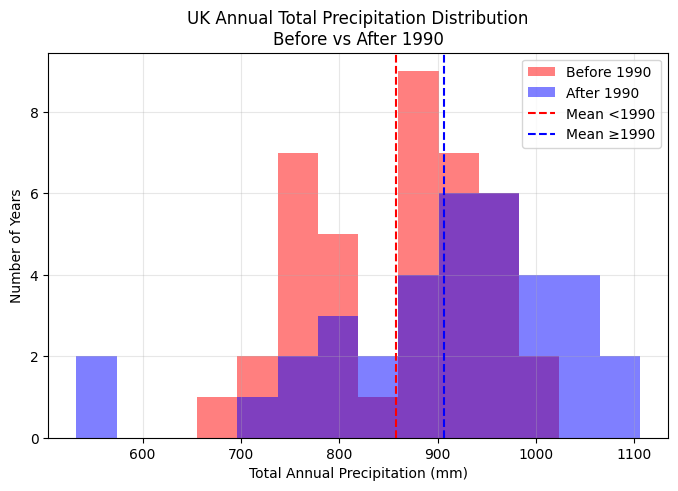

In [111]:
# histogram 

import matplotlib.pyplot as plt
import numpy as np

# --- Split the data ---
years = uk_annual_mm['year'].values
y = uk_annual_mm.values

# Mask pre- and post-1990
pre1990 = y[years < 1990]
post1990 = y[years >= 1990]

# --- Create the histogram ---
plt.figure(figsize=(8,5))
bins = np.linspace(np.nanmin(y), np.nanmax(y), 15)  # consistent bin edges for both groups

plt.hist(pre1990, bins=bins, color='red', alpha=0.5, label='Before 1990')
plt.hist(post1990, bins=bins, color='blue', alpha=0.5, label='After 1990')

# --- Labels and styling ---
plt.xlabel('Total Annual Precipitation (mm)')
plt.ylabel('Number of Years')
plt.axvline(np.nanmean(pre1990), color='red', linestyle='--', label='Mean <1990')
plt.axvline(np.nanmean(post1990), color='blue', linestyle='--', label='Mean ≥1990')
plt.title('UK Annual Total Precipitation Distribution\nBefore vs After 1990')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Found 37 station files.
Combined dataset shape: (38583, 8)

🌧️ Annual UK average precipitation (mm) for years 2022 to 2025:
year
2022     866.2
2023    1075.4
2024    1006.5
2025     597.2
Name: rain, dtype: float64

📆 Mean rainfall by month (mm) for years 2022 to 2025:
month
1      80.5
2      76.7
3      69.4
4      56.4
5      50.1
6      49.8
7      67.9
8      57.4
9      99.0
10    113.7
11    107.8
12    112.7
Name: rain, dtype: float64

📍 Mean rainfall by station (mm) for years 2022 to 2025:
station
Eskdalemuir                                            157.6
Dunstaffnage                                           134.8
Tiree                                                  108.4
Ballypatrick Forest                                    106.9
Cardiff Bute Park                                      105.7
Lerwick                                                104.2
Stornoway                                              103.6
Camborne                                                91.4

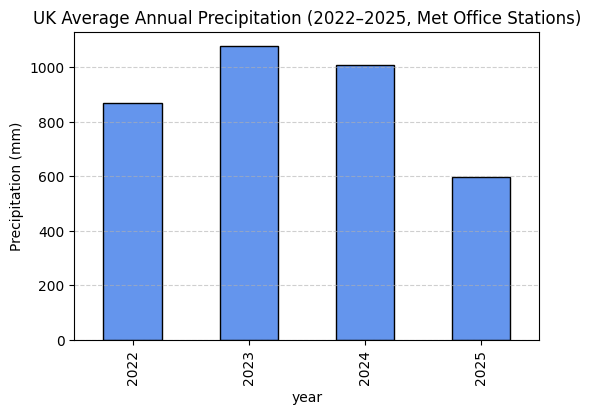

In [6]:
#Checks: 1 number for each year (averaged over locations and summed over months)

import glob
import re

# ------------------------------------------------------------
# 1️. Folder with Met Office.txt files
# ------------------------------------------------------------
folder = "/Users/ghosh/OneDrive/Documents/Year 4/Final project/MET_data/"  # change if needed
files = sorted(glob.glob(folder + "*.txt"))
print(f"Found {len(files)} station files.")

all_data = []

# ------------------------------------------------------------
# 2. Loop through all station files
# ------------------------------------------------------------
for file in files:
    with open(file, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()

    station_name = lines[0].strip()

    # Find start of numeric data
    data_start = None
    for i, line in enumerate(lines):
        if re.match(r"\s*\d{4}\s", line):
            data_start = i
            break
    if data_start is None:
        print(f" No data found in {station_name}")
        continue

    # Read numeric block — handle flexible spacing and extra words
    df = pd.read_csv(
        file,
        sep=r'\s+',
        skiprows=data_start,
        names=["year", "month", "tmax", "tmin", "af", "rain", "sun", "extra"],
        na_values=["---", " ", ""],
        engine="python",
        on_bad_lines="skip"
    )

    # Drop extra column if created
    if "extra" in df.columns:
        df = df.drop(columns=["extra"])

    # --- Clean “rain” column ---
    df["rain"] = df["rain"].astype(str)
    # Remove asterisks (*) and text like 'Provisional'
    df["rain"] = df["rain"].str.replace("*", "", regex=False)
    df["rain"] = df["rain"].str.replace("Provisional", "", regex=False)
    df["rain"] = df["rain"].str.strip()
    df["rain"] = pd.to_numeric(df["rain"], errors="coerce")

    # --- Keep valid rows ---
    df = df.dropna(subset=["year", "rain"])
    df["station"] = station_name

    all_data.append(df)

# ------------------------------------------------------------
# 3️. Combine all stations
# ------------------------------------------------------------
data = pd.concat(all_data, ignore_index=True)
print(f"Combined dataset shape: {data.shape}")

# ------------------------------------------------------------
# 4️. Filter years of interest (2022–2025)
# ------------------------------------------------------------
years_of_interest = [2022, 2023, 2024, 2025]
data = data[data["year"].isin(years_of_interest)]

# ------------------------------------------------------------
# 5️. Compute: one number per year (avg over stations, sum over months)
# ------------------------------------------------------------
annual_by_station = (
    data.groupby(["station", "year"])["rain"].sum(min_count=1).reset_index()
)

annual_mean_uk = annual_by_station.groupby("year")["rain"].mean()

# ------------------------------------------------------------
# 6️. Checks — which year, month, and stations dominate
# ------------------------------------------------------------
month_mean = data.groupby("month")["rain"].mean()
station_mean = data.groupby("station")["rain"].mean()

# ------------------------------------------------------------
# 7️. Print and plot results
# ------------------------------------------------------------
print("\n🌧️ Annual UK average precipitation (mm) for years 2022 to 2025:")
print(annual_mean_uk.round(1))

print("\n📆 Mean rainfall by month (mm) for years 2022 to 2025:")
print(month_mean.round(1))

print("\n📍 Mean rainfall by station (mm) for years 2022 to 2025:")
print(station_mean.round(1).sort_values(ascending=False).head(37))

# Plot
plt.figure(figsize=(6,4))
annual_mean_uk.plot(kind="bar", color="cornflowerblue", edgecolor="k")
plt.title("UK Average Annual Precipitation (2022–2025, Met Office Stations)")
plt.ylabel("Precipitation (mm)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()



📅 Monthly average rainfall by year (mm):
month    1      2      3     4     5     6      7     8      9      10     11  \
year                                                                            
2022   44.3  111.3   42.9  38.2  59.0  51.0   34.5  39.9   89.1  117.0  144.0   
2023   97.3   29.5  110.3  63.6  35.7  44.6  113.3  76.3   97.8  155.2  105.3   
2024   93.9  110.9   95.5  86.9  71.0  40.0   71.0  70.3  109.1   87.1   74.1   
2025   86.4   55.1   28.9  36.7  34.8  63.6   52.8  43.2  100.1   95.6    NaN   

month     12  
year          
2022    95.0  
2023   146.4  
2024    96.8  
2025     NaN  


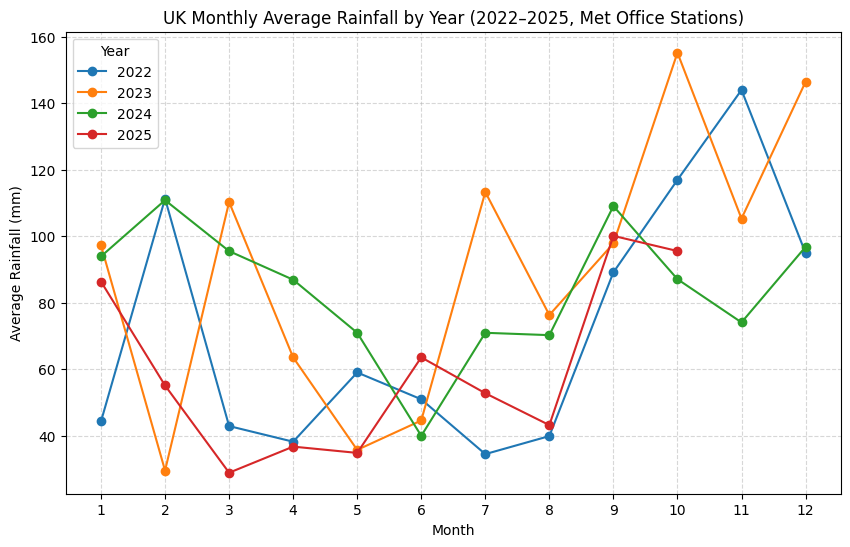

In [29]:
# ------------------------------------------------------------
# Monthly averages per year (12 numbers per year)
# ------------------------------------------------------------
monthly_by_year = data.groupby(["year", "month"])["rain"].mean().unstack()
print("\n📅 Monthly average rainfall by year (mm):")
print(monthly_by_year.round(1))

# Plot: one plot per year
plt.figure(figsize=(10,6))
for year in monthly_by_year.index:
    plt.plot(
        monthly_by_year.columns, 
        monthly_by_year.loc[year], 
        marker='o', 
        label=str(year)
    )

plt.title("UK Monthly Average Rainfall by Year (2022–2025, Met Office Stations)")
plt.xlabel("Month")
plt.ylabel("Average Rainfall (mm)")
plt.xticks(range(1,13))  # Ensure months 1-12
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Year")
plt.show()


Found 37 station files.
Combined MET rows: (29268, 8)

MET annual precipitation (1950–2025):
year
1950     915.705000
1951     948.009524
1952     788.000000
1953     693.400000
1954     975.450000
           ...     
2021     884.012903
2022     866.225806
2023    1075.432258
2024    1006.519355
2025     597.167742
Name: rain, Length: 76, dtype: float64

--- MET Office Linear Fit ---
Slope = 1.690 ± 0.507 mm/year
Intercept = 816.5 ± 22.0 mm
Z-score = 3.33
Trend (1950–2025) = 128.5 mm

--- ERA5 Linear Fit ---
Slope = 1.216 ± 0.579 mm/year
Intercept = 835.1 ± 25.2 mm
Z-score = 2.10
Trend (1950–2025) = 92.4 mm


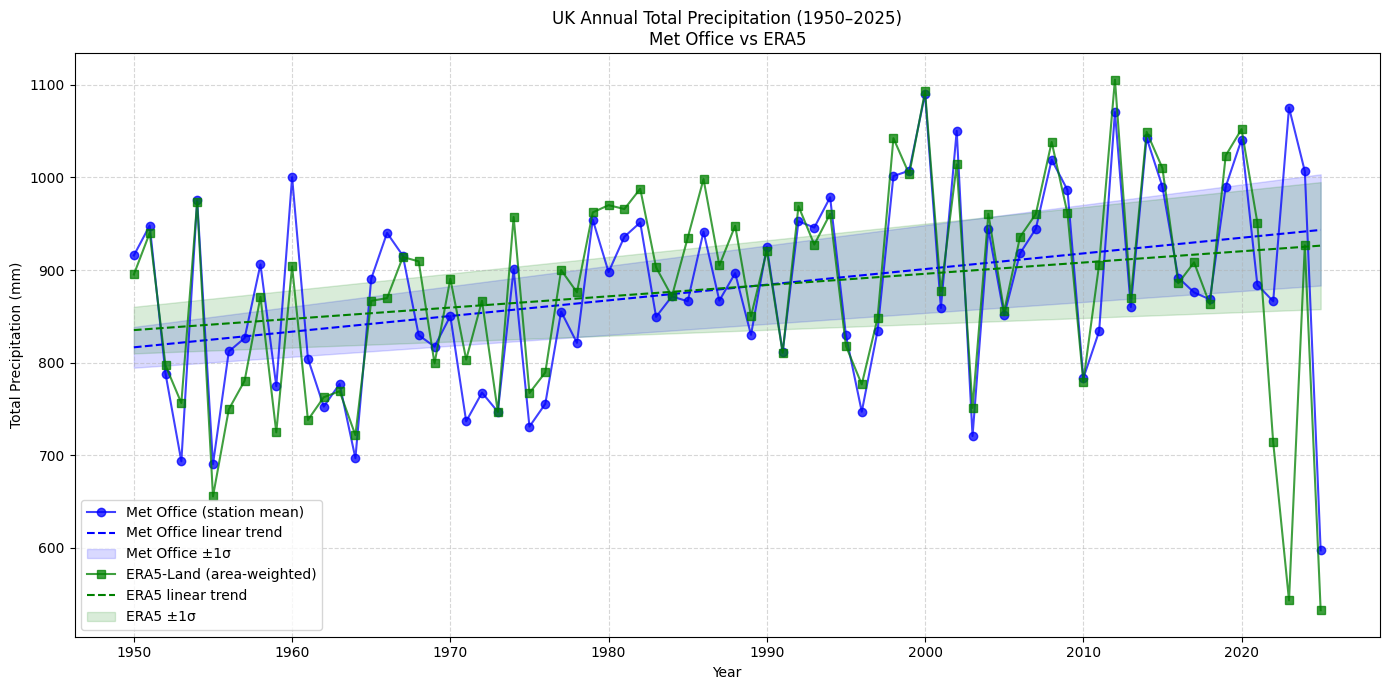

In [3]:
import glob
import re
import pandas as pd
import numpy as np
import xarray as xr
import regionmask
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# =====================================================================
# 1. LOAD & PROCESS MET OFFICE DATA (1950–2025)
# =====================================================================

folder = "/Users/ghosh/OneDrive/Documents/Year 4/Final project/MET_data/"
files = sorted(glob.glob(folder + "*.txt"))
print(f"Found {len(files)} station files.")

all_data = []

for file in files:
    with open(file, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()

    station_name = lines[0].strip()

    # Find numeric block
    data_start = None
    for i, line in enumerate(lines):
        if re.match(r"\s*\d{4}\s", line):
            data_start = i
            break
    if data_start is None:
        continue

    # Read numeric block
    df = pd.read_csv(
        file,
        sep=r"\s+",
        skiprows=data_start,
        names=["year", "month", "tmax", "tmin", "af", "rain", "sun", "extra"],
        na_values=["---", " ", ""],
        engine="python",
        on_bad_lines="skip"
    )

    # Remove extra column (contains "Provisional", etc.)
    if "extra" in df.columns:
        df = df.drop(columns=["extra"])

    # Clean rainfall
    df["rain"] = df["rain"].astype(str)
    df["rain"] = df["rain"].str.replace("*", "", regex=False)
    df["rain"] = df["rain"].str.replace("Provisional", "", regex=False)
    df["rain"] = df["rain"].str.strip()
    df["rain"] = pd.to_numeric(df["rain"], errors="coerce")

    df = df.dropna(subset=["year", "rain"])
    df["year"] = df["year"].astype(int)
    df["station"] = station_name

    all_data.append(df)

# Combine
data = pd.concat(all_data, ignore_index=True)
data = data[data["year"] >= 1950]
print("Combined MET rows:", data.shape)

# Compute MET annual rainfall averaged over stations
annual_by_station = (
    data.groupby(["station", "year"])["rain"].sum(min_count=1).reset_index()
)

met_annual = (
    annual_by_station.groupby("year")["rain"].mean()
)

print("\nMET annual precipitation (1950–2025):")
print(met_annual)

# =====================================================================
# 2. LINEAR FIT FOR MET OFFICE DATA
# =====================================================================

met_years = met_annual.index.values
met_vals = met_annual.values
x_met = np.arange(len(met_vals))

p_met, cov_met = np.polyfit(x_met, met_vals, 1, cov=True)
met_slope, met_intercept = p_met
met_slope_err, met_intercept_err = np.sqrt(np.diag(cov_met))
met_z = met_slope / met_slope_err

print("\n--- MET Office Linear Fit ---")
print(f"Slope = {met_slope:.3f} ± {met_slope_err:.3f} mm/year")
print(f"Intercept = {met_intercept:.1f} ± {met_intercept_err:.1f} mm")
print(f"Z-score = {met_z:.2f}")
print(f"Trend (1950–2025) = {met_slope * len(met_vals):.1f} mm")

# Compute MET trend line and error bands
met_fit = np.polyval(p_met, x_met)
met_fit_upper = np.polyval([met_slope + met_slope_err, met_intercept + met_intercept_err], x_met)
met_fit_lower = np.polyval([met_slope - met_slope_err, met_intercept - met_intercept_err], x_met)

# =====================================================================
# 3. LOAD & PROCESS ERA5 DATA
# =====================================================================

file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/totprecip.nc'
ds = xr.open_dataset(file_path)
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
varname = 'tp'

# Monthly → yearly totals
days_in_month = ds['valid_time'].dt.days_in_month
monthly_total = ds[varname] * days_in_month
yearly_totals = monthly_total.groupby("valid_time.year").sum(dim="valid_time")

# Mask for UK
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index("United Kingdom")
uk_mask = countries.mask(yearly_totals) == uk_index
uk_data = yearly_totals.where(uk_mask)

lat_rad = np.deg2rad(uk_data["lat"])
weights = np.cos(lat_rad)

uk_weighted = (
    (uk_data * weights).sum(dim=["lat", "lon"], skipna=True) /
    weights.where(~np.isnan(uk_data)).sum(dim=["lat", "lon"], skipna=True)
)

era5_annual_mm = uk_weighted * 1000  # m → mm

# =====================================================================
# 4. ERA5 LINEAR FIT
# =====================================================================

years = era5_annual_mm["year"].values
y = era5_annual_mm.values
x = np.arange(len(y))

p, cov = np.polyfit(x, y, 1, cov=True)
slope, intercept = p
slope_err, intercept_err = np.sqrt(np.diag(cov))
z_score = slope / slope_err

print("\n--- ERA5 Linear Fit ---")
print(f"Slope = {slope:.3f} ± {slope_err:.3f} mm/year")
print(f"Intercept = {intercept:.1f} ± {intercept_err:.1f} mm")
print(f"Z-score = {z_score:.2f}")
print(f"Trend (1950–2025) = {slope * len(y):.1f} mm")

# ERA5 trend curve
y_fit = np.polyval(p, x)
y_fit_upper = np.polyval([slope + slope_err, intercept + intercept_err], x)
y_fit_lower = np.polyval([slope - slope_err, intercept - intercept_err], x)

# =====================================================================
# 5. PLOT — BOTH DATASETS, BOTH TRENDS, BOTH ERROR BANDS
# =====================================================================

plt.figure(figsize=(14,7))

# MET Office Data
plt.plot(met_years, met_vals, 'o-', color='blue', label="Met Office (station mean)", alpha=0.75)
plt.plot(met_years, met_fit, 'b--', label="Met Office linear trend")
plt.fill_between(met_years, met_fit_lower, met_fit_upper, color='blue', alpha=0.15, label="Met Office ±1σ")

# ERA5 Data
plt.plot(years, y, 's-', color='green', label="ERA5-Land (area-weighted)", alpha=0.75)
plt.plot(years, y_fit, 'g--', label="ERA5 linear trend")
plt.fill_between(years, y_fit_lower, y_fit_upper, color='green', alpha=0.15, label="ERA5 ±1σ")

plt.title("UK Annual Total Precipitation (1950–2025)\nMet Office vs ERA5")
plt.xlabel("Year")
plt.ylabel("Total Precipitation (mm)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
import xarray as xr

file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/7variables.nc'
ds = xr.open_dataset(file_path)

print("VARIABLES IN FILE:")
print(ds.data_vars)


VARIABLES IN FILE:
Data variables:
    t2m      (valid_time, latitude, longitude) float32 53MB ...
    skt      (valid_time, latitude, longitude) float32 53MB ...
    sde      (valid_time, latitude, longitude) float32 53MB ...
    swvl1    (valid_time, latitude, longitude) float32 53MB ...
    sshf     (valid_time, latitude, longitude) float32 53MB ...
    ssrd     (valid_time, latitude, longitude) float32 53MB ...
    e        (valid_time, latitude, longitude) float32 53MB ...


Dataset dims: FrozenMappingWarningOnValuesAccess({'valid_time': 910, 'latitude': 121, 'longitude': 121})
Dataset variables: ['t2m', 'skt', 'sde', 'swvl1', 'sshf', 'ssrd', 'e']
Years found: 1950 - 2025
Common years used for all variables: 1950 - 2025


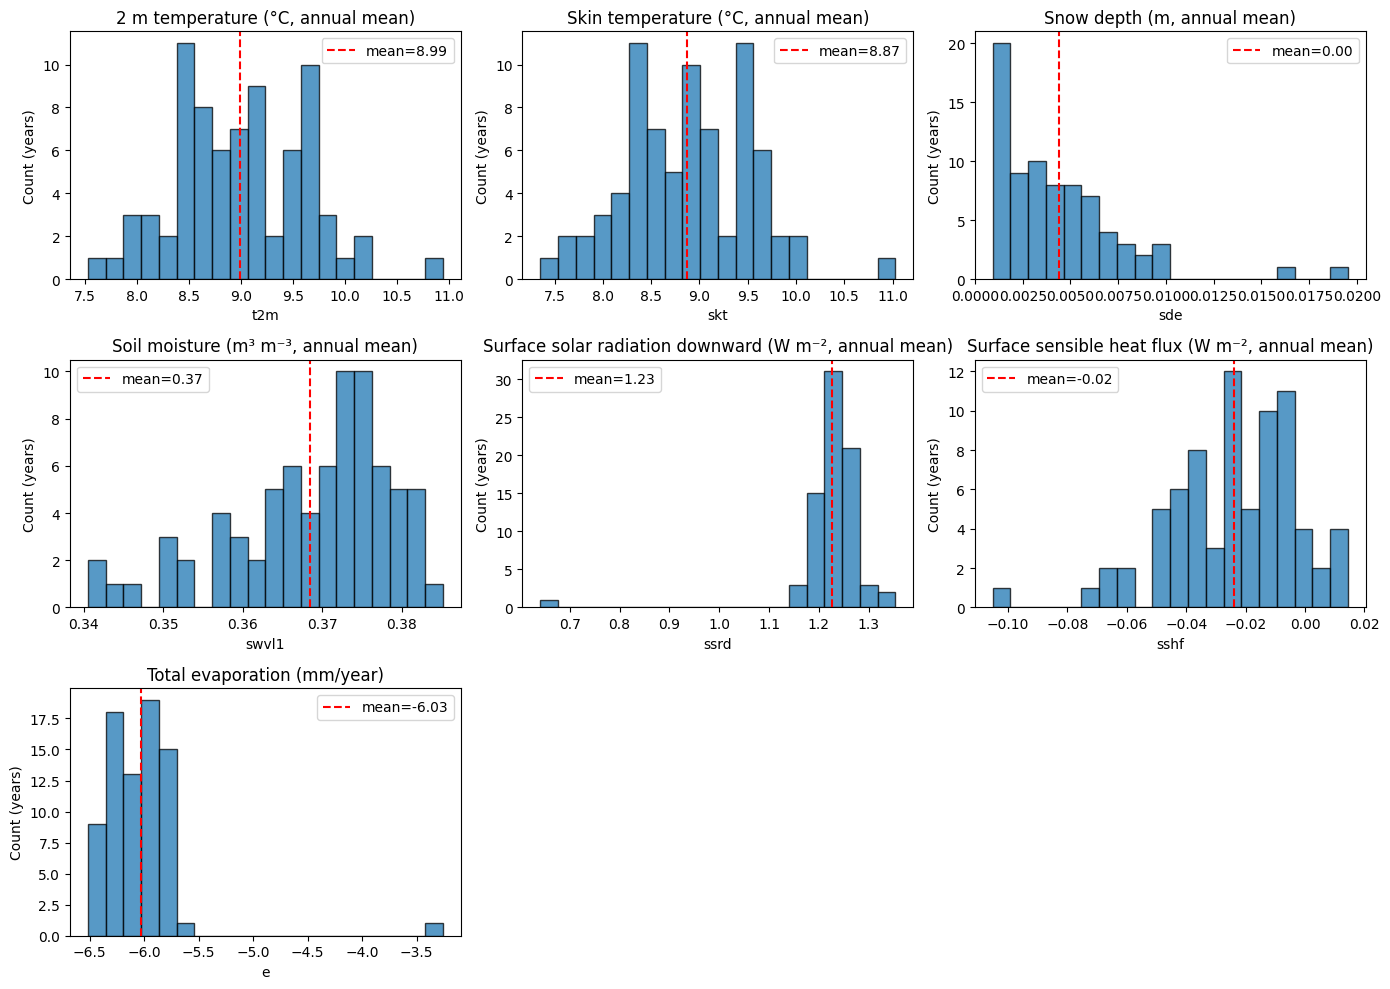


Summary (per-variable annual UK mean/total):
t2m    | years=76 | mean=8.988 | std=0.633 | min=7.529 | max=10.943
skt    | years=76 | mean=8.875 | std=0.660 | min=7.352 | max=11.029
sde    | years=76 | mean=0.004 | std=0.003 | min=0.001 | max=0.020
swvl1  | years=76 | mean=0.368 | std=0.010 | min=0.341 | max=0.385
ssrd   | years=76 | mean=1.226 | std=0.078 | min=0.641 | max=1.353
sshf   | years=76 | mean=-0.024 | std=0.021 | min=-0.105 | max=0.014
e      | years=76 | mean=-6.029 | std=0.389 | min=-6.517 | max=-3.261


In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# File & UK bounding box
# -----------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/7variables.nc'
ds = xr.open_dataset(file_path)

# Confirm coordinate names present:
print("Dataset dims:", ds.dims)
print("Dataset variables:", list(ds.data_vars))

# UK bounds (N, S, E, W)
N, S, E, W = 61, 49, 2, -10

# NOTE: your dataset uses 'latitude' (descending) and 'longitude'
# For slicing latitude descending (N -> S), use slice(N, S)
uk = ds.sel(latitude=slice(N, S), longitude=slice(W, E))

# -----------------------
# Variables & categories
# -----------------------
# According to the file you printed earlier these exist:
# t2m, skt, sde, swvl1, sshf, ssrd, e
instantaneous = ["t2m", "skt", "sde", "swvl1"]     # take time-mean (annual mean)
accumulated = ["e", "ssrd", "sshf"]               # sum over time to get annual totals, then convert

vars_to_process = ["t2m", "skt", "sde", "swvl1", "ssrd", "sshf", "e"]

# -----------------------
# Prepare lat weights for area-weighting
# -----------------------
# weights should be 1D over latitude and broadcastable to lon
lat = uk["latitude"]
lon = uk["longitude"]
lat_rad = np.deg2rad(lat)
weights = np.cos(lat_rad)  # dimension: latitude

# We'll create a helper that computes an area-weighted mean over lat/lon for each time slice
def area_weighted_mean_over_space(da, weights):
    """
    da: xarray DataArray with dims (year, latitude, longitude) or (latitude, longitude) for a single year.
    weights: 1D array on latitude
    Returns: area-weighted scalar (or 1D over year)
    """
    # expand weights so they broadcast with da (latitude, longitude)
    w = weights.broadcast_like(da)
    # Multiply, sum ignoring nan, divide by sum of weights (only where da is not nan)
    num = (da * w).sum(dim=("latitude", "longitude"), skipna=True)
    denom = w.where(~np.isnan(da)).sum(dim=("latitude", "longitude"), skipna=True)
    return num / denom

# -----------------------
# Compute yearly series (area-weighted)
# -----------------------
# The time coordinate is 'valid_time' in your file.
time_coord = "valid_time"
years = uk[time_coord].dt.year.values
year_values = np.unique(years)
print("Years found:", year_values.min(), "-", year_values.max())

# We'll build a dict {varname: xarray.Series-like (index=year, values=annual_country_value)}
annual_series = {}

# Seconds per year for converting J m^-2 (annual total) -> W m^-2
seconds_per_year = 365.25 * 24 * 3600.0

for var in vars_to_process:
    if var in instantaneous:
        # compute annual mean in time first (mean over valid_time for each year), then area-weight
        # groupby year -> mean over time within the group
        yearly = uk[var].groupby(uk[time_coord].dt.year).mean(dim=time_coord)  # dims: year, lat, lon
        # compute area-weighted mean for each year
        # result will be DataArray indexed by 'year'
        weighted = area_weighted_mean_over_space(yearly, weights)
        # convert units where appropriate
        if var in ["t2m", "skt"]:
            # Kelvin -> Celsius
            weighted = weighted - 273.15
        # sde and swvl1 left in native units (m and m3/m3)
        annual_series[var] = weighted
    elif var in accumulated:
        # sum over time to get annual totals (units: e->m, ssrd/sshf -> J m^-2 (annual total))
        yearly_total = uk[var].groupby(uk[time_coord].dt.year).sum(dim=time_coord)  # dims: year, lat, lon
        # area-weight the annual total
        weighted_total = area_weighted_mean_over_space(yearly_total, weights)  # DataArray indexed by year
        # Convert units to more interpretable forms:
        if var == "e":
            # meters of water per year -> mm/year
            weighted_total = weighted_total * 1000.0
        elif var in ["ssrd", "sshf"]:
            # accumulated J m^-2 per year -> mean W m^-2 (divide by seconds in year)
            weighted_total = weighted_total / seconds_per_year
        annual_series[var] = weighted_total
    else:
        raise ValueError(f"Unknown variable category for {var}")

# -----------------------
# Check results + convert to numpy arrays for plotting
# -----------------------
# Align years between variables (some variables might lack earliest/last years):
common_years = None
for var, da in annual_series.items():
    y = da["year"].values
    if common_years is None:
        common_years = y
    else:
        # take intersection to be safe
        common_years = np.intersect1d(common_years, y)

print("Common years used for all variables:", common_years.min(), "-", common_years.max())

# Reindex each series to the common years
for var in list(annual_series.keys()):
    annual_series[var] = annual_series[var].sel(year=common_years)

# -----------------------
# Plot histograms (Option A: histogram of annual UK values)
# -----------------------
titles = {
    "t2m": "2 m temperature (°C, annual mean)",
    "skt": "Skin temperature (°C, annual mean)",
    "sde": "Snow depth (m, annual mean)",
    "swvl1": "Soil moisture (m³ m⁻³, annual mean)",
    "ssrd": "Surface solar radiation downward (W m⁻², annual mean)",
    "sshf": "Surface sensible heat flux (W m⁻², annual mean)",
    "e": "Total evaporation (mm/year)"
}

plt.figure(figsize=(14, 10))
n_vars = len(vars_to_process)
ncols = 3
nrows = int(np.ceil(n_vars / ncols))

for i, var in enumerate(vars_to_process, start=1):
    data = annual_series[var].values.flatten()
    data = data[~np.isnan(data)]
    plt.subplot(nrows, ncols, i)
    # histogram of annual values (one point per year)
    plt.hist(data, bins=20, edgecolor='k', alpha=0.75)
    plt.title(titles.get(var, var))
    plt.xlabel(var)
    plt.ylabel("Count (years)")
    # print mean & std on plot
    mu = np.nanmean(data)
    sigma = np.nanstd(data)
    plt.axvline(mu, color='red', linestyle='--', label=f"mean={mu:.2f}")
    plt.legend()

plt.tight_layout()
plt.show()

# -----------------------
# Print summary statistics
# -----------------------
print("\nSummary (per-variable annual UK mean/total):")
for var in vars_to_process:
    arr = annual_series[var].values.flatten()
    print(f"{var:6s} | years={len(arr)} | mean={np.nanmean(arr):.3f} | std={np.nanstd(arr):.3f} | min={np.nanmin(arr):.3f} | max={np.nanmax(arr):.3f}")


In [ ]:
# snow depth, total evaporation and soil moisture need to multiply by total number of days in the month

Dataset dims: FrozenMappingWarningOnValuesAccess({'valid_time': 910, 'latitude': 121, 'longitude': 121})
Dataset variables: ['t2m', 'skt', 'sde', 'swvl1', 'sshf', 'ssrd', 'e']


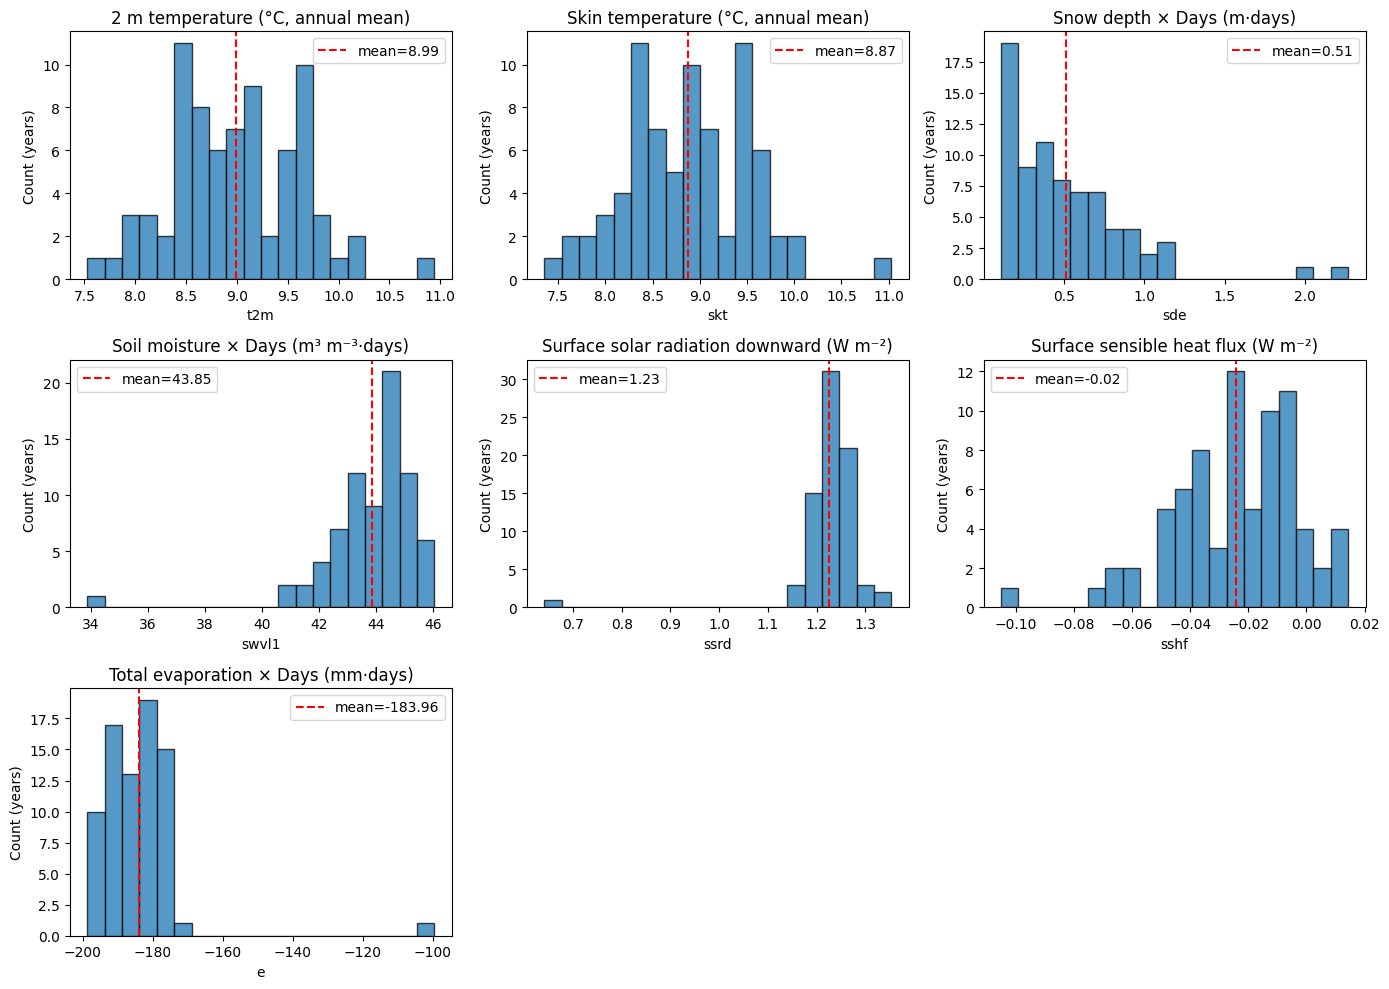


Summary (per-variable annual UK mean/total):
t2m    | years=76 | mean=8.988 | std=0.633 | min=7.529 | max=10.943
skt    | years=76 | mean=8.875 | std=0.660 | min=7.352 | max=11.029
sde    | years=76 | mean=0.515 | std=0.384 | min=0.109 | max=2.267
swvl1  | years=76 | mean=43.855 | std=1.647 | min=33.888 | max=46.041
ssrd   | years=76 | mean=1.226 | std=0.078 | min=0.641 | max=1.353
sshf   | years=76 | mean=-0.024 | std=0.021 | min=-0.105 | max=0.014
e      | years=76 | mean=-183.958 | std=11.861 | min=-198.646 | max=-99.488


In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# File & UK bounding box
# -----------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/7variables.nc'
ds = xr.open_dataset(file_path)

# Confirm coordinate names present:
print("Dataset dims:", ds.dims)
print("Dataset variables:", list(ds.data_vars))

# UK bounds (N, S, E, W)
N, S, E, W = 61, 49, 2, -10

# NOTE: your dataset uses 'latitude' (descending) and 'longitude'
uk = ds.sel(latitude=slice(N, S), longitude=slice(W, E))

# -----------------------
# Variables & categories
# -----------------------
vars_to_process = ["t2m", "skt", "sde", "swvl1", "ssrd", "sshf", "e"]

instantaneous = ["t2m", "skt"]             # time-mean only
accumulated_scaled = ["sde", "swvl1", "e"] # multiply by days before summing
accumulated_raw = ["ssrd", "sshf"]         # sum over time only

# -----------------------
# Prepare lat weights for area-weighting
# -----------------------
lat = uk["latitude"]
lon = uk["longitude"]
lat_rad = np.deg2rad(lat)
weights = np.cos(lat_rad)

def area_weighted_mean_over_space(da, weights):
    """Compute area-weighted mean over lat/lon for each time slice or year."""
    w = weights.broadcast_like(da)
    num = (da * w).sum(dim=("latitude", "longitude"), skipna=True)
    denom = w.where(~np.isnan(da)).sum(dim=("latitude", "longitude"), skipna=True)
    return num / denom

# -----------------------
# Days in month for scaling
# -----------------------
days = uk["valid_time"].dt.days_in_month
days_3d = days.broadcast_like(uk["t2m"])

# -----------------------
# Compute yearly series
# -----------------------
annual_series = {}
seconds_per_year = 365.25 * 24 * 3600.0

for var in vars_to_process:
    if var in instantaneous:
        yearly = uk[var].groupby(uk["valid_time"].dt.year).mean(dim="valid_time")
        weighted = area_weighted_mean_over_space(yearly, weights)
        if var in ["t2m", "skt"]:
            weighted = weighted - 273.15
        annual_series[var] = weighted
    elif var in accumulated_scaled:
        # multiply by number of days in month
        scaled = uk[var] * days_3d
        yearly_total = scaled.groupby(uk["valid_time"].dt.year).sum(dim="valid_time")
        weighted_total = area_weighted_mean_over_space(yearly_total, weights)
        if var == "e":
            weighted_total = weighted_total * 1000.0  # m → mm
        annual_series[var] = weighted_total
    elif var in accumulated_raw:
        yearly_total = uk[var].groupby(uk["valid_time"].dt.year).sum(dim="valid_time")
        weighted_total = area_weighted_mean_over_space(yearly_total, weights)
        if var in ["ssrd", "sshf"]:
            weighted_total = weighted_total / seconds_per_year
        annual_series[var] = weighted_total
    else:
        raise ValueError(f"Unknown variable category for {var}")

# -----------------------
# Align years
# -----------------------
common_years = None
for var, da in annual_series.items():
    y = da["year"].values
    if common_years is None:
        common_years = y
    else:
        common_years = np.intersect1d(common_years, y)

for var in annual_series.keys():
    annual_series[var] = annual_series[var].sel(year=common_years)

# -----------------------
# Plot histograms
# -----------------------
titles = {
    "t2m": "2 m temperature (°C, annual mean)",
    "skt": "Skin temperature (°C, annual mean)",
    "sde": "Snow depth × Days (m·days)",
    "swvl1": "Soil moisture × Days (m³ m⁻³·days)",
    "ssrd": "Surface solar radiation downward (W m⁻²)",
    "sshf": "Surface sensible heat flux (W m⁻²)",
    "e": "Total evaporation × Days (mm·days)"
}

plt.figure(figsize=(14, 10))
n_vars = len(vars_to_process)
ncols = 3
nrows = int(np.ceil(n_vars / ncols))

for i, var in enumerate(vars_to_process, start=1):
    data = annual_series[var].values.flatten()
    data = data[~np.isnan(data)]
    plt.subplot(nrows, ncols, i)
    plt.hist(data, bins=20, edgecolor='k', alpha=0.75)
    plt.title(titles.get(var, var))
    plt.xlabel(var)
    plt.ylabel("Count (years)")
    mu = np.nanmean(data)
    plt.axvline(mu, color='red', linestyle='--', label=f"mean={mu:.2f}")
    plt.legend()

plt.tight_layout()
plt.show()

# -----------------------
# Print summary statistics
# -----------------------
print("\nSummary (per-variable annual UK mean/total):")
for var in vars_to_process:
    arr = annual_series[var].values.flatten()
    print(f"{var:6s} | years={len(arr)} | mean={np.nanmean(arr):.3f} | std={np.nanstd(arr):.3f} | min={np.nanmin(arr):.3f} | max={np.nanmax(arr):.3f}")


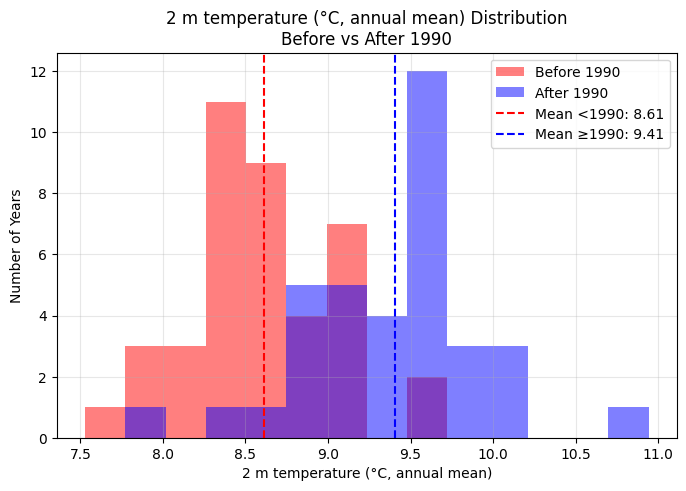

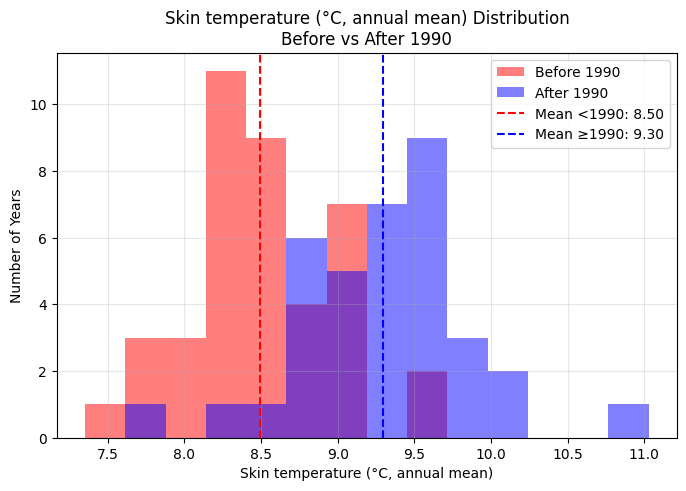

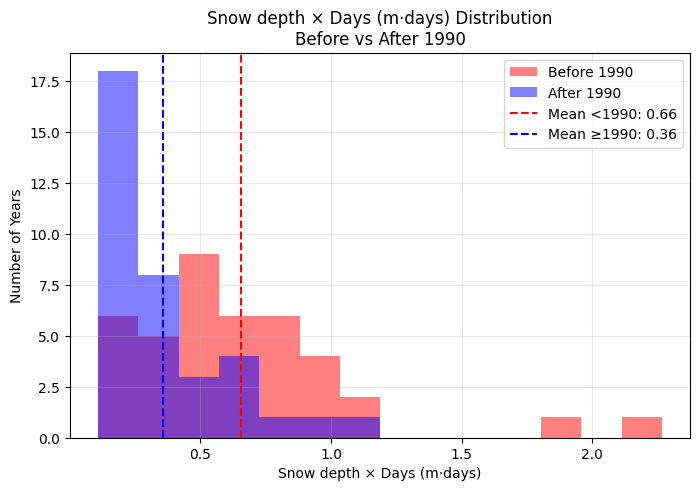

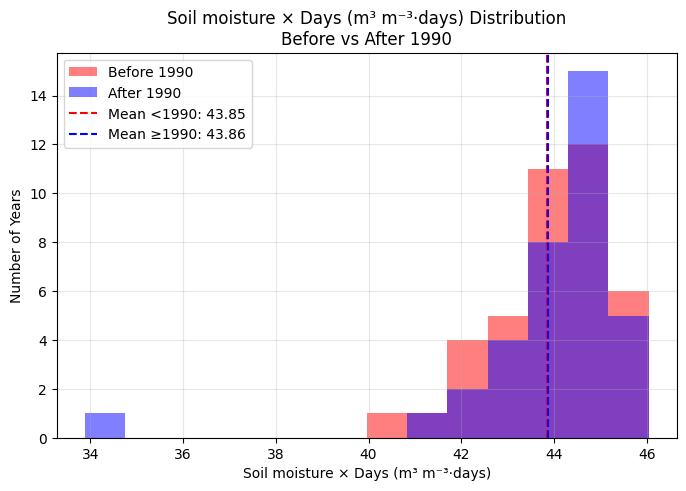

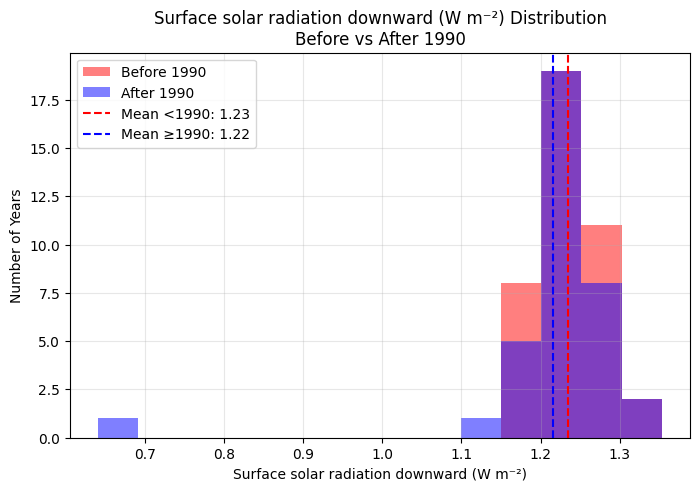

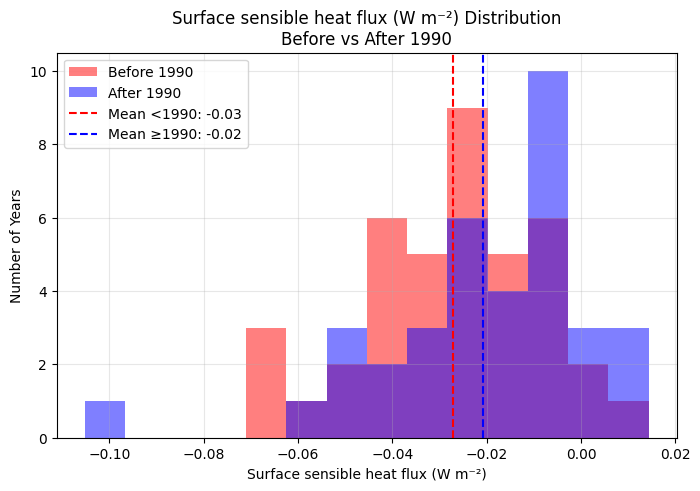

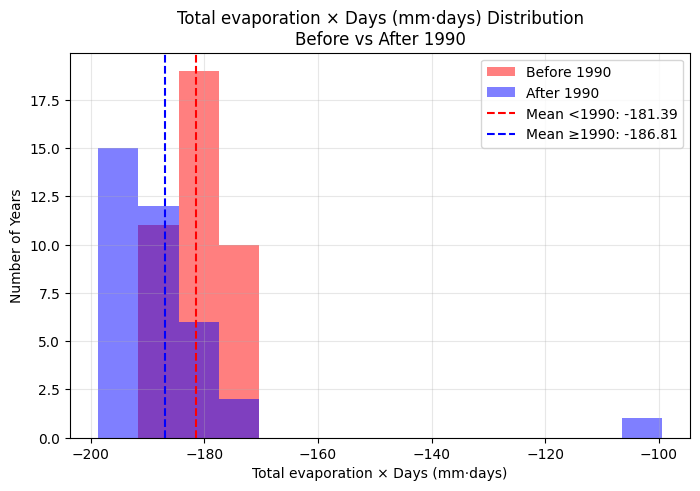

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Use the already computed annual_series dict from previous code
# annual_series[var] → DataArray indexed by year, area-weighted UK annual value

for var in vars_to_process:
    da = annual_series[var]
    years = da["year"].values
    values = da.values
    
    # Mask pre-1990 and post-1990
    pre1990 = values[years < 1990]
    post1990 = values[years >= 1990]
    
    # --- Create the histogram ---
    plt.figure(figsize=(8,5))
    bins = np.linspace(np.nanmin(values), np.nanmax(values), 15)  # consistent bins
    
    plt.hist(pre1990, bins=bins, color='red', alpha=0.5, label='Before 1990')
    plt.hist(post1990, bins=bins, color='blue', alpha=0.5, label='After 1990')
    
    # --- Labels and styling ---
    plt.xlabel(titles.get(var, var))
    plt.ylabel('Number of Years')
    plt.axvline(np.nanmean(pre1990), color='red', linestyle='--', label=f'Mean <1990: {np.nanmean(pre1990):.2f}')
    plt.axvline(np.nanmean(post1990), color='blue', linestyle='--', label=f'Mean ≥1990: {np.nanmean(post1990):.2f}')
    plt.title(f'{titles.get(var, var)} Distribution\nBefore vs After 1990')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()



================= T2M =================
Slope      = 0.0187 ± 0.0026  per year
Intercept  = 8.29 ± 0.11
Z-score    = 7.33
Total trend (1950–2025): 1.422 over 76 years


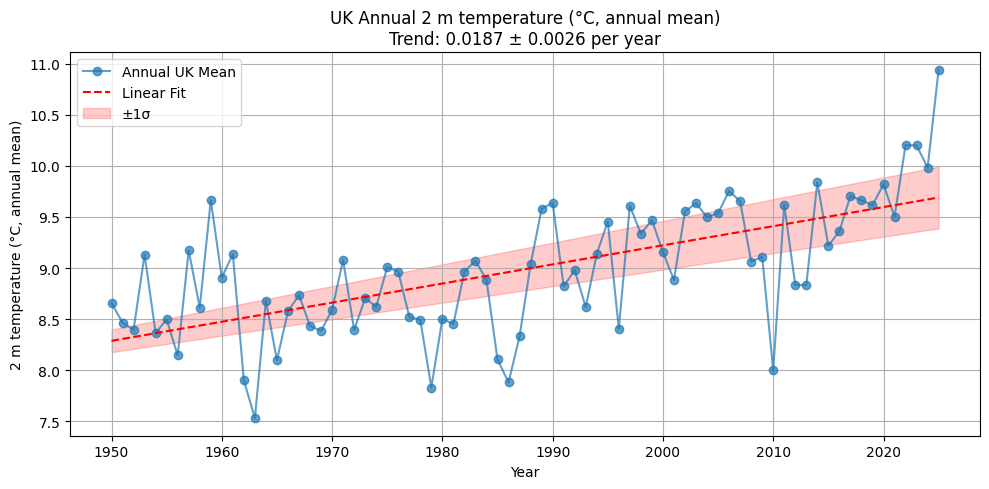


================= SKT =================
Slope      = 0.0191 ± 0.0027  per year
Intercept  = 8.16 ± 0.12
Z-score    = 7.04
Total trend (1950–2025): 1.449 over 76 years


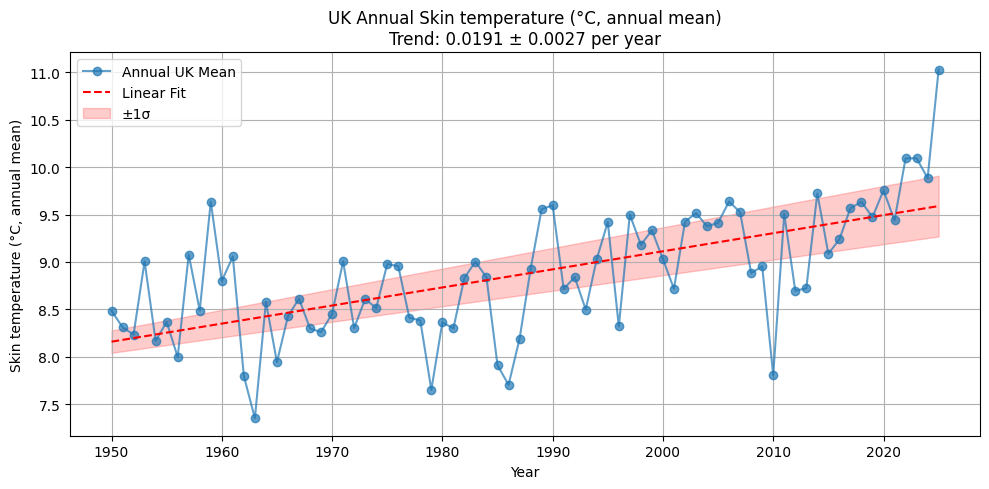


================= SDE =================
Slope      = -0.0059 ± 0.0019  per year
Intercept  = 0.74 ± 0.08
Z-score    = -3.11
Total trend (1950–2025): -0.452 over 76 years


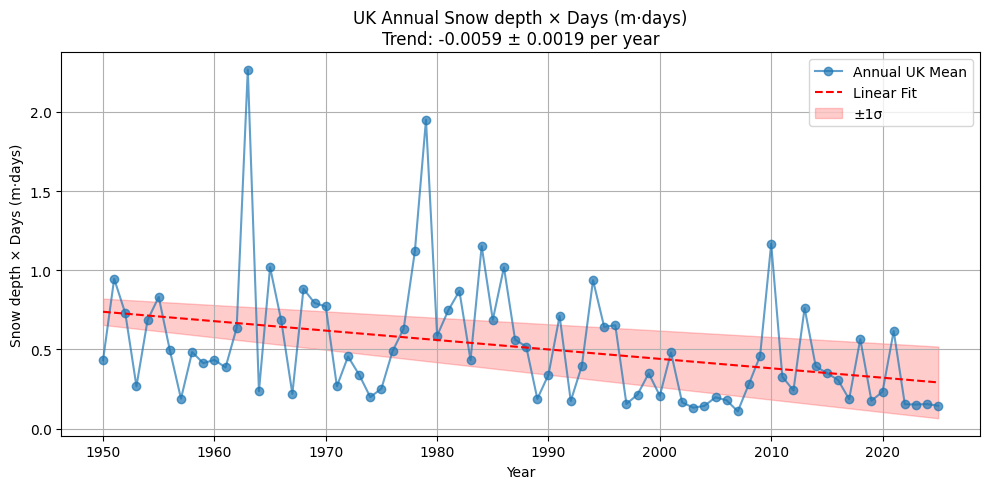


================= SWVL1 =================
Slope      = 0.0008 ± 0.0087  per year
Intercept  = 43.82 ± 0.38
Z-score    = 0.09
Total trend (1950–2025): 0.061 over 76 years


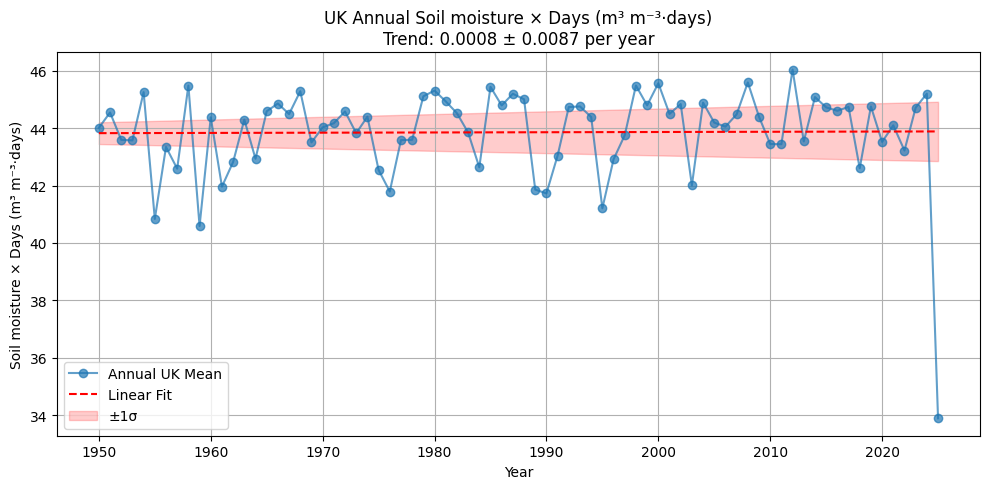


================= SSRD =================
Slope      = -0.0008 ± 0.0004  per year
Intercept  = 1.26 ± 0.02
Z-score    = -2.10
Total trend (1950–2025): -0.064 over 76 years


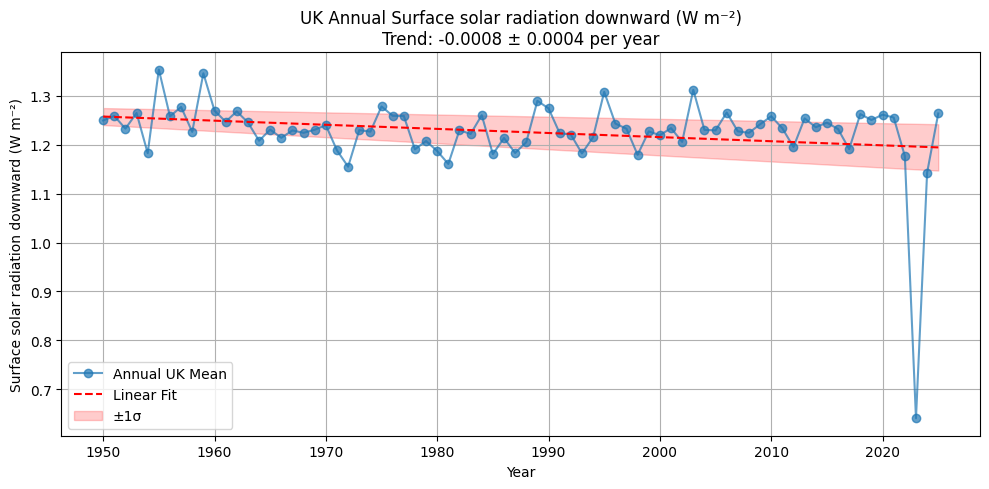


================= SSHF =================
Slope      = 0.0001 ± 0.0001  per year
Intercept  = -0.03 ± 0.00
Z-score    = 1.04
Total trend (1950–2025): 0.009 over 76 years


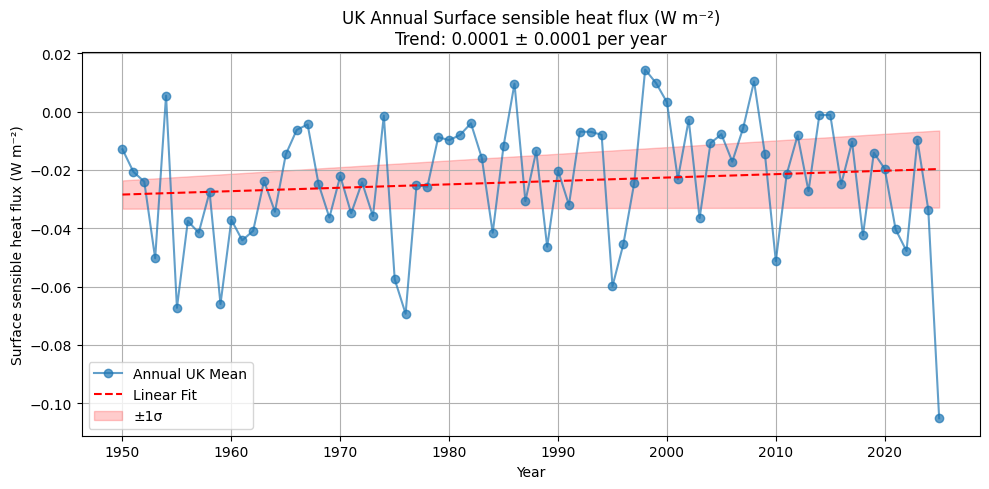


================= E =================
Slope      = -0.0786 ± 0.0622  per year
Intercept  = -181.01 ± 2.70
Z-score    = -1.26
Total trend (1950–2025): -5.973 over 76 years


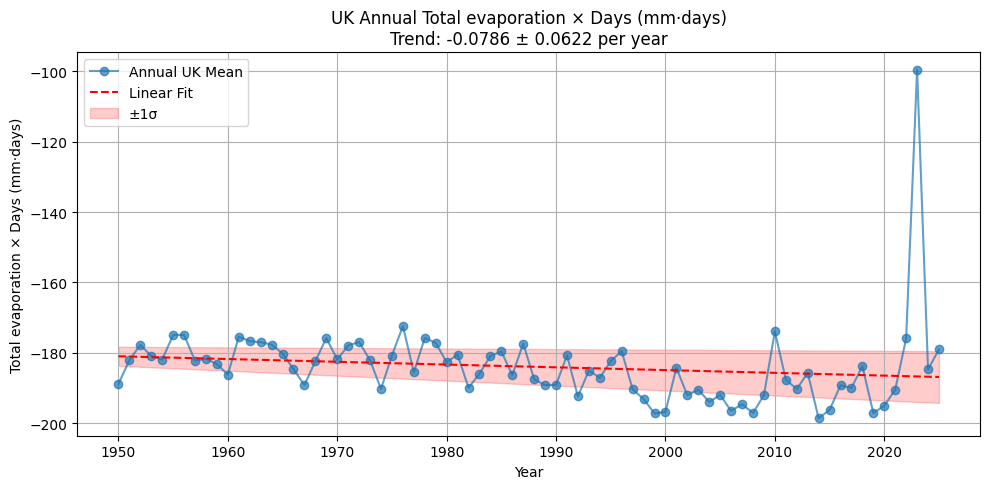

In [14]:
import numpy as np
import matplotlib.pyplot as plt

for var in vars_to_process:

    da = annual_series[var]           # DataArray (year → value)
    years = da["year"].values
    y = da.values
    x = np.arange(len(y))

    # -------------------------
    # Linear Fit with covariance
    # -------------------------
    p, cov = np.polyfit(x, y, 1, cov=True)
    slope, intercept = p
    slope_err, intercept_err = np.sqrt(np.diag(cov))

    z_score = slope / slope_err

    # Compute fitted line + uncertainty envelope
    y_fit = np.polyval(p, x)
    y_fit_upper = np.polyval([slope + slope_err, intercept + intercept_err], x)
    y_fit_lower = np.polyval([slope - slope_err, intercept - intercept_err], x)

    # -------------------------
    # Print stats
    # -------------------------
    print(f"\n================= {var.upper()} =================")
    print(f"Slope      = {slope:.4f} ± {slope_err:.4f}  per year")
    print(f"Intercept  = {intercept:.2f} ± {intercept_err:.2f}")
    print(f"Z-score    = {z_score:.2f}")
    print(f"Total trend ({years[0]}–{years[-1]}): {slope * len(y):.3f} over {len(y)} years")

    # -------------------------
    # Plot
    # -------------------------
    plt.figure(figsize=(10,5))
    plt.plot(years, y, "o-", alpha=0.7, label="Annual UK Mean")

    plt.plot(years, y_fit, "r--", label="Linear Fit")
    plt.fill_between(years, y_fit_lower, y_fit_upper,
                     color="r", alpha=0.2, label="±1σ")

    plt.xlabel("Year")
    plt.ylabel(titles[var])
    plt.title(f"UK Annual {titles[var]}\nTrend: {slope:.4f} ± {slope_err:.4f} per year")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
